# Donor Data: A Kaggle Classic

Here's some work I did for an interview process.  The primary question was "what would you do to quickly identify donors who might enhance their donation level?"  --So whatever we do, it shouldn't take too long.

## TLDR:

To quickly identify target donors, we will try to find donors with lower levels of donation who resemble higher level donors in all respects except their donation level.  <-- We do this rapidly by visually confirming intuitions about years of employment and donation level in the data, and then breaking out donors according to this principle.

Next, we begin to look at further attribute correlations on donation level, and get modest analytic gains with marital, business and engagement indicators.

Finally, we note that regional grouping attributes, income level, and above all longitudinal data would probably help the most as data additions.


In [1]:
# imports

import pandas as pd
import openpyxl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from sklearn import preprocessing as prep
from faker import Faker

# Source Material

https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a
https://cooldata.files.wordpress.com/2018/01/cool-data-a-handbook-for-predictive-modeling.pdf

Original Set At:
https://www.kaggle.com/datasets/michaelpawlus/fundraising-data/code

### Auxiliary Defs:

Here are some python defs for processing this specific raw data with pandas.  I didn't end up using all of them.

In [37]:
def process_strdollars(val):
    val=float(val.replace('$','').replace(',',''))
    return val

In [43]:
def conditional_log(val):
    if val!=0:
        val=np.log(val)
    return val

In [2]:
def impute_gender(row):
    val=0
    
    if row['Prefix is Mr.']==1:
        val='M'
    elif row['Prefix is Ms.']==1:
        val='F'
    elif row['Prefix is Mrs.']==1:
        val='F'
    else:
        val='OU'
    
    return val

In [3]:
def rec_mar_status(val):
    retval=val
    
    if pd.isna(val)==True:
        retval='NA'
    elif val not in ('M','U','S'):
        retval='O'
    return retval

# Retrieving Data

I load the data below as a csv, but first I docotored it in postgres on the desktop to take advantage of window functions and some other things as follows:

drop table if exists cool_unv_data;

CREATE TABLE IF NOT EXISTS cool_unv_data 
(
	id_number int,
	LifetimeHC 	text,
	Email_Present int,
	BusPhone_Present int,
	Grad_Year int,
	Marital_Status varchar,
	SpouseID_Present int,
	JobTitle_Present int,
	VarsityAth_Present int,
	StudGovt_Present int,
	OtherStudActs_Present int,
	Greek_Present int,
	Prefix_is_Mr int,
	Prefix_is_Ms int,
	Prefix_is_Dr int,
	Prefix_is_Mrs int
);


COPY cool_unv_data 
FROM '/Users/ouonomos/Documents/cool_data-university-sample-file-Sheet1.tsv' DELIMITERS E'\t' 
CSV HEADER
;


drop table if exists  tab1;

create temp table tab1 as 
select
t1.*
,case when lhc_clean>0 then log(lhc_clean) else lhc_clean end log_lhc -- taking log of lhc data
from
(
	select 
	t1.*
	,cast(replace(replace(t1.lifetimehc,'$',''),',','') as float) as lhc_clean -- cleaning lhc data
	,2018-t1.grad_year as years_since_grad -- artificially using 2018 as the "present" against which the users graduate year is compared, based 
												-- on data being loaded 5 years ago.
	,case when t1.Prefix_is_Mr=1 then 'M' -- imputing gender based on prefix
		when t1.prefix_is_ms=1 then 'F'
		when t1.prefix_is_mrs=1 then 'F'
		else 'OU'
		end imputed_gender
	from cool_unv_data t1
) t1
;

drop table if exists  tab2;

create temp table tab2
as
select 
t1.*
,ntile(10) over (order by log_lhc asc) as donor_lhc_decile
,ntile(4) over (order by log_lhc asc) as donor_lhc_quartile from tab1 t1
;


COPY (select * from tab2) TO '/Users/ouonomos/Documents/cool_unv_data2.tsv'  CSV  HEADER DELIMITER E'\t';



## Key Data Notes

### LHC, "Donor LCH Decile", and "Donor LHC Quartile"

The key dependent variable is "lifetime HC" or lifetime hard credit, meaning the direct donor donations for which the donor received a tax credit.  We abbreviate "lifetime HC" to "LHC" below.

As noted in the https://cooldata.files.wordpress.com/2018/01/cool-data-a-handbook-for-predictive-modeling.pdf ...
taming lhc outlers by taking the log is a good move.  But we should also transform that log into deciles and quartiles for easier stakeholder consumption.  

I also grouped the honorifics (e.g. "is Mr.") columns into an "imputed gender" category on the hunch that this would gather more explanatory power and was the analytic point of those categories anyway.  After which I dropped the honorific columns.

In [4]:
# retrieving sql output...

df = pd.read_csv('/Users/ouonomos/Documents/cool_unv_data2.tsv', sep='\t')
df.head()

,id_number,lifetimehc,email_present,busphone_present,grad_year,marital_status,spouseid_present,jobtitle_present,varsityath_present,studgovt_present,...,prefix_is_mr,prefix_is_ms,prefix_is_dr,prefix_is_mrs,lhc_clean,years_since_grad,imputed_gender,log_lhc,donor_lhc_decile,donor_lhc_quartile
0,1053807,$0.25,1,0,2001,S,0,0,0,0,...,1,0,0,0,0.25,17,M,-0.60206,1,1
1,1053757,$0.25,0,0,2001,U,0,0,0,0,...,1,0,0,0,0.25,17,M,-0.60206,1,1
2,1078367,$0.00,1,0,2003,M,0,1,0,0,...,1,0,0,0,0.00,15,M,0.00000,1,1
3,1023190,$0.00,1,0,1979,M,0,1,0,0,...,0,0,0,0,0.00,39,OU,0.00000,1,1
4,1053899,$0.00,0,0,2001,NaN,0,0,0,0,...,0,1,0,0,0.00,17,F,0.00000,1,1


# Intuition: Years Earning Will Be Driver of Donation Level

## The Graduate Year Concept

If you were to look at the book noted above, you'd find that "year graduated" is in inverse correlation to the log of LHC, which makes sense ... you will have less money to donate if you haven't graduated, or haven't been earning as long as a graduate. There are no rows with missing graduate years.  I turned "year graduated" into "years since grad" variable by subtracting it from 2018 (2018 based on kaggle upload date).

5000

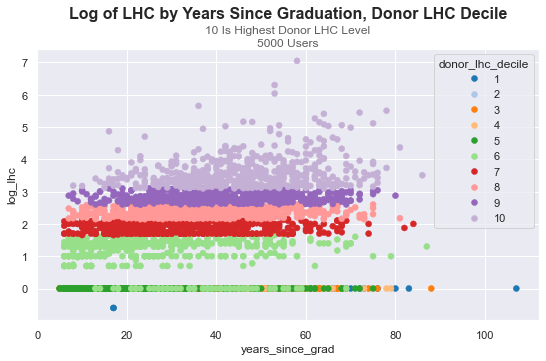

In [7]:
# n.b. :
# https://stackoverflow.com/questions/31594549/how-to-change-the-figure-size-of-a-seaborn-axes-or-figure-level-plot
# https://seaborn.pydata.org/generated/seaborn.move_legend.html
# https://stackoverflow.com/questions/26139423/plot-different-color-for-different-categorical-levels

sns.set(rc={'figure.figsize':(9,5)})
ax=sns.scatterplot(x='years_since_grad', y='log_lhc', data=df, hue='donor_lhc_decile', ec=None, palette="tab20")
ax.text(x=0.5, y=1.1, s='Log of LHC by Years Since Graduation, Donor LHC Decile', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='10 Is Highest Donor LHC Level', fontsize=12, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1, s='5000 Users', fontsize=12, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

df.shape[0]

Above, you can see a positive relationship between log_lhc and years since graduation.  But it's suspicious ... a great bulk of the data points are very old.  We'll to have to be better informed about the meaning of this variable, and qualify it per some "still alive" or "years left to donate" concept.

Let's use cap the years after graduation to <=30 so that the set is limited to users with 30 years of earning opportunity after graduation.  

2733

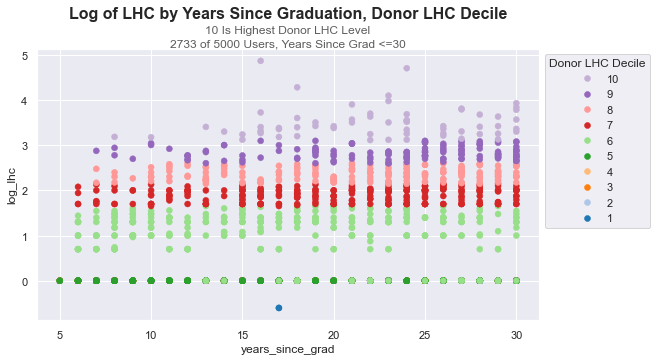

In [8]:

df2=df.loc[(df['years_since_grad']<=30)]
sns.set(rc={'figure.figsize':(9,5)})
ax=sns.scatterplot(x='years_since_grad', y='log_lhc', data=df2, hue='donor_lhc_decile', ec=None, palette="tab20")

ax.text(x=0.5, y=1.1, s='Log of LHC by Years Since Graduation, Donor LHC Decile', fontsize=16, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1.05, s='10 Is Highest Donor LHC Level', fontsize=12, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)
ax.text(x=0.5, y=1, s='2733 of 5000 Users, Years Since Grad <=30', fontsize=12, alpha=0.75, ha='center', va='bottom', transform=ax.transAxes)

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc='upper left',title='Donor LHC Decile', bbox_to_anchor=(1, 1))
df2.shape[0]

This is quite suggestive.  At around 16 years we begin to get donors in the higher deciles. Other factors constant (a big if), years since graduation begins to tell us something about the level of donation we can suggest to donor. Also, we can see that in every range of years after graduation there is potential to move donors up from lower donation levels.  

## Continuing to Work Graduate Year Concept...

Now let's break down donor lhc to illustrate a common quick way to get at potential opportunities.

The idea is to breakout levels of giving (here, quartiles of log LHC) by other explanatory categories, and look for areas of overlap.  For example, the donor levels 1-3 on years since graduation and marital status. 

What we're aiming for is something like "These donors are in the same earning window (years since grad) and have the same marital status, but are at a lower giving tier.  Maybe we should approach them."  This is a basic routine you would extend for additionally fine grain, and for different combinations of variables, according to your intuition.

In reality, you have to keep looking at finer grains of user descriptives until you're satisfied that the user groups are sufficiently "alike" that their only difference is their donation level. -- Years since graduation + marital status isn't sufficient, but this illustrates a relatively quick approach to take.

In [9]:
# n.b. df2 is the frame filtered on years_since_grad where donations are >0

column_order=["min", "max"]
table = pd.pivot_table(df2, values=['years_since_grad'], index=['donor_lhc_quartile', 'spouseid_present'],
                       aggfunc={'years_since_grad': ["min", "max"]})
table

years_since_grad    
                                                 max min
donor_lhc_quartile spouseid_present                     
1                  0                              30   5
                   1                              30   7
2                  0                              30   5
                   1                              30   7
3                  0                              30   6
                   1                              30   6
4                  0                              30   7
                   1                              30  11

# On to Regression Review

The breakouts of relationship between LHC and years since graduation above illustrates a quick approach from intuition.

The use of spouse id was informed by a slower regression-based approach illustrated below.  The regression approach to identifying variables that drive lhc is outlined in the source material noted above; and the below borrows from it.  In real life, I would tend to start with logistic as a baseline rather than linear as shown here, because you'd hope IRL to have real longitudinal data showing user before-and-after donation behavior.


# A Spot of Feature Engineering ...

Doing some onehot on marital for the greatest frequencies of marital status after bucketing the small freq cats.



In [10]:
# recode for greatest frequency, keeping NaN
df['marital_status_rec']=df['marital_status'].apply(rec_mar_status)
df = pd.get_dummies(df, columns=['marital_status_rec','imputed_gender'], dtype=int)

In [12]:
df.columns

Index(['id_number', 'lifetimehc', 'email_present', 'busphone_present',
       'grad_year', 'marital_status', 'spouseid_present', 'jobtitle_present',
       'varsityath_present', 'studgovt_present', 'otherstudacts_present',
       'greek_present', 'prefix_is_mr', 'prefix_is_ms', 'prefix_is_dr',
       'prefix_is_mrs', 'lhc_clean', 'years_since_grad', 'log_lhc',
       'donor_lhc_decile', 'donor_lhc_quartile', 'marital_status_rec_M',
       'marital_status_rec_NA', 'marital_status_rec_O', 'marital_status_rec_S',
       'marital_status_rec_U', 'imputed_gender_F', 'imputed_gender_M',
       'imputed_gender_OU'],
      dtype='object')

# Reviewing Correlation ...

We can do some quick checks to review correlation between the log of LHC and potential explantory variables.  The lighter the color the higher the correlation.

It is possible to iteratively choose between explanatory variables that correlate with each other, selecting just one such variable so as to avoid overfitting and multi-collinearity.  --We ignore that here given the simplicity of the set, in favor of choosing among highest correlation variables by rank.

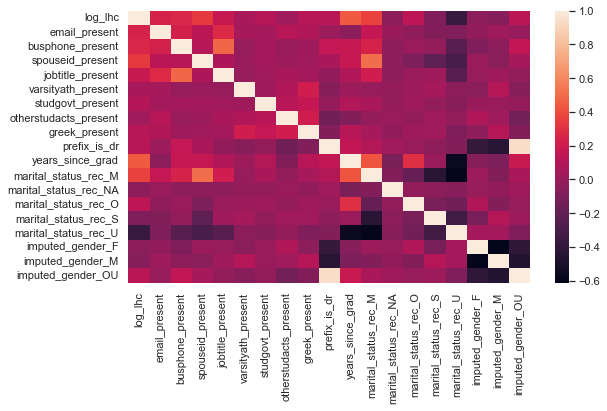

In [13]:
corr_eval_columns=['log_lhc','email_present', 'busphone_present',
       'spouseid_present', 'jobtitle_present',
       'varsityath_present', 'studgovt_present', 'otherstudacts_present',
       'greek_present','prefix_is_dr','years_since_grad','marital_status_rec_M',
       'marital_status_rec_NA', 'marital_status_rec_O', 'marital_status_rec_S',
       'marital_status_rec_U','imputed_gender_F', 'imputed_gender_M','imputed_gender_OU']
sns.heatmap(df[corr_eval_columns].corr());

In [14]:
df[corr_eval_columns].corr()[['log_lhc']].sort_values(by='log_lhc', ascending=False)

,log_lhc
log_lhc,1.000000
years_since_grad,0.441914
marital_status_rec_M,0.369081
spouseid_present,0.337671
busphone_present,0.262517
email_present,0.240848
jobtitle_present,0.181078
marital_status_rec_O,0.141047
imputed_gender_OU,0.125847
prefix_is_dr,0.122937


# Basic Multivar Regression

Exactly like the book.  This is never a bad exploration. Interestingly, my one-hot on marital_status_rec_M gives me more correlation, but a little less r2, presumably because spouseid_present is more general.

The basic finding is that years since grad, having a spouse id, and indications of business and accessibility are the strongest predictors of giving in the set.  They would be good candidates for further breakouts like the example above.

In [15]:
x_explain=df[['years_since_grad','spouseid_present','busphone_present','email_present']]
x_explain = sm.add_constant(x_explain)
ks = sm.OLS(df['log_lhc'],x_explain)
ks_res =ks.fit()
print(ks_res.summary())

                            OLS Regression Results                            
Dep. Variable:                log_lhc   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     614.4
Date:                Wed, 06 Dec 2023   Prob (F-statistic):               0.00
Time:                        10:20:25   Log-Likelihood:                -7594.4
No. Observations:                5000   AIC:                         1.520e+04
Df Residuals:                    4995   BIC:                         1.523e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.3410      0.038  

# Additional Directions

Having made a pass at the above set, what other data might I bring in?  There are two potential complementary directions that I'm sure are obvious to everyone:

1. Above all, longitudinal data.  You want to see the user in a historical context: "first the user was at one donation level, then something happened, and the level changed."
2. Variables that focus the users demographically.  So for example user zipcodes, neighborhoods, etc.  The idea is to refine them so that you can group scalars like lifetime hc and disposable income and see how much of an outlier a user is relative to their group.  A lower level donor within a demo group of higher donors who are demographically identical = better prospect.  
2. Disposable income.  This is gnarly to do yourself; you're likely to need a vendor. Again, these complement your demographic grouping categorical variables.